In [1]:
from mpmath import mp, mpf, mpc
mp.dps = 1000

In [2]:
def series_expansion(z, c, tolerance=mp.eps * mpf(1e3)):
    zz = mpf(1)
    r = 0
    q = 0
    while zz > tolerance:
        r += c(q) * zz
        zz *= z
        q += 1
    return r
    

def series_coeffs(m):
    cache = {}
    def of_q(q):
        nonlocal cache
        if q in cache:
            return cache[q]
        if m == -1:
            r = 1/mp.factorial(2*q)
        else:
            r = mp.factorial(q+m)/mp.factorial(q)/mp.factorial(2*q + 2*m + 1)
        cache[q] = r
        return r
    
    return of_q
    
expansion = [series_coeffs(m) for m in range(-1, 51)]
    
def exact(z):
    z = mpf(z)
    if -0.2 < z < 0.2:
        return [(1 if k == 0 else 2**(k-1))  * series_expansion(z, e) for k, e in enumerate(expansion)]
    else:
        sz = mp.sqrt(mpc(z))
        eta = [mp.cosh(sz), mp.sinh(sz)/sz]
        for m in range(1, 51):
            eta.append((eta[m-1] - (2*m-1)*eta[m])/z)

        for e in eta:
            assert mp.fabs(e.imag) < mpf('1e-30')

        return [e.real for e in eta]

In [3]:
exact(-50)[15]

mpf('0.000000000000000070618560463150849230589162435944339645023963674214897485834293120795722102423590456514787030954187179213627726826193178015797839310458314235774772609184133629556119960358506218326548433244805412864055752275546926990871796548356908295244697635412426060721305204571859894755333326591454778646893776180037181899591260675130982789563752377294666595084279761293038473681239768833534988242421384756876822050901503964746508183665341244243053470138949094448177057401675821669628285292431529101376466997702418674820420780319916883564697606363309580100315486617835899712636877134617311981737416569907152411275649126606838335941866440194043495002339898311421290044374881251666297372776809542781536289136482004279424530392493153221471028294192225985508023475797844371073703456318201692257599029439468419187576568649653856471175194771254669760771336543105798313811874676440708845398144085294427824044890452671079456532789201357709767208982796117685500176457000478508690926438203808811762234

In [4]:
q = 0
m = 14
float(2**m * mp.factorial(q+m)/(mp.factorial(q) * mp.factorial(2*q+2*m+1)))

1.6154349370997664e-16

In [5]:
float(exact(-50)[m])

1.9278929452129993e-15

In [6]:
float(exact(-50)[m+1])

7.061856046315085e-17

In [7]:
list(map(float, exact(-50)))[:m+2]

[0.7053479063084424,
 0.10024812527586707,
 -0.012101995620651505,
 -0.002731082242756432,
 -3.106831186261307e-05,
 5.0272081194362807e-05,
 9.670340852237566e-06,
 1.1220333636050085e-06,
 9.832185749255087e-08,
 7.055889975665094e-09,
 4.325654418751144e-10,
 2.3257068399241608e-11,
 1.116659890179186e-12,
 4.852218149759344e-14,
 1.9278929452129993e-15,
 7.061856046315085e-17]

In [8]:
data = {}

with open('test_eta_liviu.txt') as tel:
    for line in tel:
        splitted = line.split()
        if len(splitted) == 6:
            sz, z, i, m1, m2, err = splitted
            z = float(z)
            i = int(i)
            data[(z, i)] = [mpf(m1), mpf(m2), None, None, None]
            
with open('test_eta_matslise.txt') as tel:
    for line in tel:
        splitted = line.split()
        if len(splitted) == 6:
            sz, z, i, m_d, m_ld, m_q = splitted
            z = float(z)
            i = int(i)
            data[(z, i)][-3:] = map(mpf, [m_d, m_ld, m_q])

table = []            
zs = set(z for z, i in data.keys())
eta = {z: exact(z) for z in sorted(zs)}
for (z, i), l in data.items():
    e = eta[z][i+1]
    sz = float(mp.sqrt(mp.fabs(z)))
    if z < 0:
        sz = -sz
    table.append([z, sz, i, *[None if m is None else float(mp.fabs((m-e)/e)) for m in l]])

import pandas as pd
df = pd.DataFrame(table, columns=['z', 'sz', 'i', 'liviu1', 'liviu2', 'double', 'long_double', 'float128'])

In [9]:
df[df.i == 6]

,z,sz,i,liviu1,liviu2,double,long_double,float128
7,16.00,4.0,6,5.335699e-16,1.911282e-16,4.589454e-13,2.995188e-16,6.765898e-31
59,12.25,3.5,6,1.081051e-15,3.556919e-16,3.257129e-15,5.302438e-16,1.497033e-30
111,9.00,3.0,6,6.385722e-16,1.151737e-15,9.202292e-12,9.695080e-16,4.116121e-30
163,6.25,2.5,6,6.214944e-16,2.475162e-16,6.218658e-12,2.448678e-14,5.933393e-29
215,4.00,2.0,6,9.749755e-16,1.817757e-16,1.513442e-10,3.231523e-14,1.533311e-28
267,2.25,1.5,6,8.565605e-16,8.565605e-16,2.912258e-09,7.244554e-13,2.990084e-27
319,1.00,1.0,6,5.389989e-16,3.498512e-16,5.647122e-08,1.053090e-10,2.869098e-25
371,0.25,0.5,6,4.799680e-16,5.385391e-16,3.107152e-16,8.790087e-20,2.301271e-34
423,-0.00,0.0,6,8.388370e-16,5.009995e-16,4.154050e-17,1.081180e-20,1.000000e-36
475,-0.25,-0.5,6,4.583495e-16,1.040569e-16,1.275960e-16,7.962350e-21,2.492985e-34


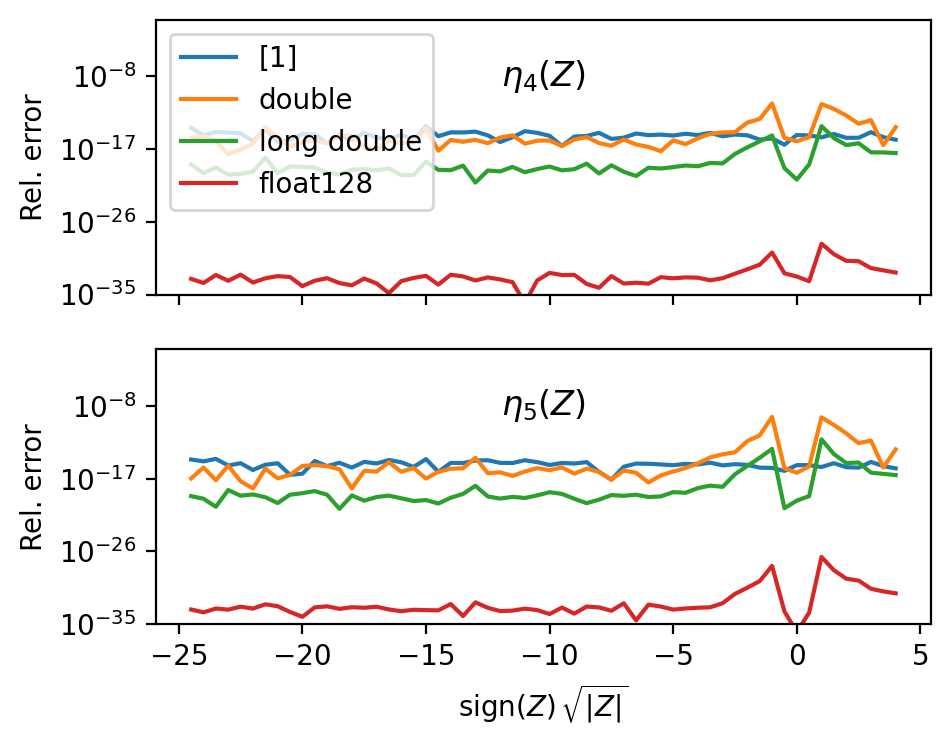

In [21]:
import matplotlib.pyplot as plt

i_s = range(4, 6)

fig, axes = plt.subplots(len(i_s), 1, sharex=True, figsize=(5, len(i_s)*2), dpi=200)

for j, i in enumerate(i_s):
    ax = axes[j]
    ax.set_title(f"$\\eta_{{{i}}}(Z)$", loc="center", y=0.7)
    ax.set_yscale('log',base=10) 
    ax.set_ylim(10**-35, 10**-1)
    fdf = df[df.i == i]
    for r, l in [('liviu2', "[1]"), ('double', 'double'), ('long_double', 'long double'), ('float128', 'float128')]:
        ax.plot(fdf.sz, fdf[r], label=l)
    ax.set_ylabel("Rel. error")
axes[0].legend(loc="upper left")
axes[-1].set_xlabel("$\operatorname{sign}(Z)\,\\sqrt{|Z|}$")
plt.savefig("tested_eta_zoom.pdf", bbox_inches="tight")
plt.savefig("tested_eta_zoom.png", bbox_inches="tight", dpi=500)

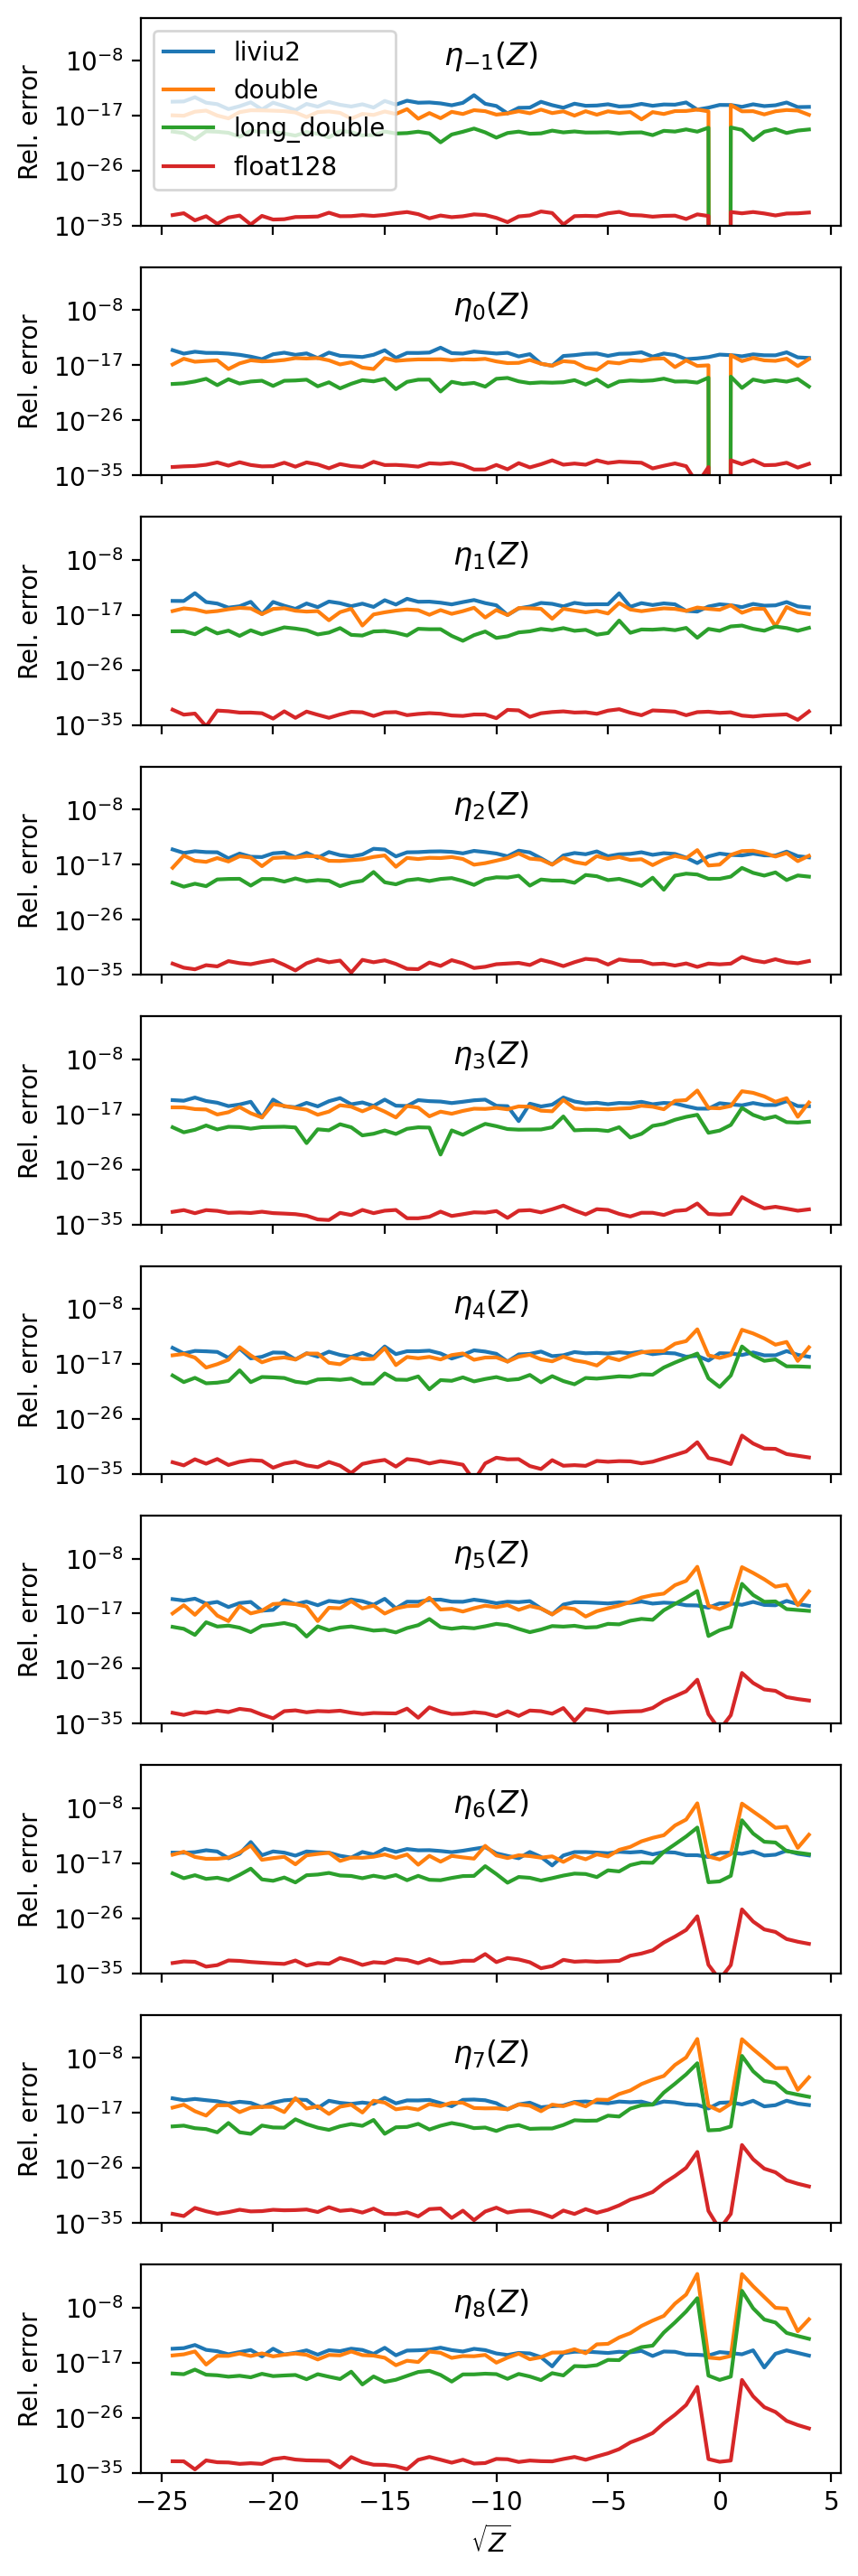

In [157]:
import matplotlib.pyplot as plt

n = 8

fig, axes = plt.subplots(n + 2, 1, sharex=True, figsize=(5, (n+1)*2), dpi=200)

for i in range(-1, n+1):
    ax = axes[i+1]
    ax.set_title(f"$\\eta_{{{i}}}(Z)$", loc="center", y=0.7)
    ax.set_yscale('log',base=10) 
    ax.set_ylim(10**-35, 10**-1)
    fdf = df[df.i == i]
    for r in ['liviu2', 'double', 'long_double', 'float128']:
        ax.plot(fdf.sz, fdf[r], label=r)
    ax.set_ylabel("Rel. error")
axes[0].legend(loc="upper left")
axes[-1].set_xlabel("$\sqrt{Z}$")
plt.savefig("tested_eta.pdf", bbox_inches="tight")

In [156]:
import numpy as np
np.finfo(np.longdouble).eps

1.084202172485504434e-19

In [107]:
df[df.i == 6]['double']

7       4.589454e-13
59      3.257129e-15
111     9.202292e-12
163     6.218658e-12
215     1.513442e-10
267     2.912258e-09
319     5.647122e-08
371     3.107152e-16
423     4.154050e-17
475     1.275960e-16
527     6.236734e-08
579     1.378071e-10
631     1.481894e-11
683     3.774172e-13
735     1.410984e-13
787     3.818522e-14
839     4.786980e-15
891     1.570862e-15
943     1.261481e-16
995     2.807223e-16
1047    4.507617e-17
1099    1.555073e-16
1151    1.676779e-17
1203    1.342301e-16
1255    8.185721e-17
1307    1.488015e-16
1359    2.005066e-16
1411    7.061428e-17
1463    1.914279e-16
1515    7.019905e-15
1567    5.676996e-17
1619    9.079559e-17
1671    1.591220e-16
1723    1.807628e-17
1775    1.634093e-16
1827    5.797499e-18
1879    2.686715e-16
1931    7.599633e-17
1983    2.734382e-16
2035    1.155271e-16
2087    7.808737e-17
2139    8.401767e-17
2191    2.395283e-17
2243    5.287091e-16
2295    3.343251e-16
2347    1.943388e-16
2399    6.679153e-18
2451    1.127